In [1]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *
from tensorflow.keras.layers import (
    Input, Conv2D, BatchNormalization, Activation,
    Add, MaxPooling2D, GlobalAveragePooling2D,
    Dense, Dropout 
)
from tensorflow.keras.applications import ResNet50, Xception, DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc,accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.preprocessing import label_binarize
import seaborn as sns
import numpy as np
import random
from PIL import Image
import os
import shutil

In [2]:
input_path = '/kaggle/input/facescrub-full'
print("محتويات المجلد:", os.listdir(input_path))

محتويات المجلد: ['actress_faces', 'actor_faces']


In [ ]:
# نسخ الصور للستات

actress_dir = '/kaggle/input/facescrub-full/actress_faces'
merged_faces_path = "/kaggle/working/merged_faces"  # مسار المجلد الجديد

# إنشاء المجلد "merged_faces" إذا لم يكن موجودًا
if not os.path.exists(merged_faces_path):
    os.makedirs(merged_faces_path)
def copy_images(src_dir, target_dir):
    for folder_name in os.listdir(src_dir):
        folder_path = os.path.join(src_dir, folder_name)
        if os.path.isdir(folder_path):
            # هنعمل فايل نضيف فيه الصور
            target_folder = os.path.join(target_dir, folder_name)
            os.makedirs(target_folder, exist_ok=True)
            
            # نسخ الصور من المجلد الأصلي للجديد
            for img_name in os.listdir(folder_path):
                src_img_path = os.path.join(folder_path, img_name)
                target_img_path = os.path.join(target_folder, img_name)
                shutil.copy(src_img_path, target_img_path)

copy_images(actress_dir, merged_faces_path)

print("تم إضافة صور الممثلات بنجاح.")

In [ ]:
actor_names ="/kaggle/input/facescrub-full/actor_faces"
copy_images(actor_names, merged_faces_path)
print("تم إضافة صور الممثلين يعم بنجاح.")

In [ ]:
# outbut_file='/kaggle/working/merged_faces'
# os.listdir(outbut_file)

In [3]:
data_path = "/kaggle/input/facescrub-full/actress_faces"

# عرض الصور
def display_images(path, num_images=10):
    image_files = []
    
    # قراءة كل الصور في الفايل و إضافتها لقائمة الصور
    for img in os.listdir(path):
        img_path = os.path.join(path, img)
        if os.path.isfile(img_path) and img.endswith(('.jpeg', '.jpg', '.png')):
            image_files.append(img_path)

    # عشوائيات
    random.shuffle(image_files)
    
    # عرض الصور
    for i, img_path in enumerate(image_files[:num_images]):
        img = Image.open(img_path)
        plt.subplot(1, num_images, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

# عرض الأسماء 
print("First 5 Image Names:")
image_files = os.listdir(data_path)
print(image_files[:10])

display_images(data_path)


First 5 Image Names:
['Courteney_Cox', 'Farah_Fath', 'Tina_Louise', 'Fran_Drescher', 'Melissa_Gilbert', 'Lisa_LoCicero', 'Dianna_Agron', 'Sharon_Gless', 'Shannon_Kane', 'Geena_Davis']


In [4]:
class_counts = {}
for class_name in os.listdir(data_path):
    class_dir = os.path.join(data_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

# ترتيب الكلاسات بناءً على عدد الصور واختيار أعلى 50
top_classes = sorted(class_counts, key=class_counts.get, reverse=True)[:50]
print(f"Top 50 classes: {top_classes}")


Top 50 classes: ['Kristin_Chenoweth', 'America_Ferrera', 'Felicity_Huffman', 'Holly_Marie_Combs', 'Fran_Drescher', 'Geena_Davis', 'Debra_Messing', 'Courteney_Cox', 'Julie_Benz', 'Neve_Campbell', 'Glenn_Close', 'Christina_Applegate', 'Tina_Fey', 'Julianna_Margulies', 'Christa_Miller', 'Julia_Louis-Dreyfus', 'Miranda_Cosgrove', 'Sarah_Michelle_Gellar', 'Dianna_Agron', 'Jessica_Capshaw', 'Eva_Longoria', 'Joan_Collins', 'Kim_Cattrall', 'Lisa_Kudrow', 'Sarah_Hyland', 'Victoria_Justice', 'Marcia_Cross', 'Gillian_Anderson', 'Roma_Downey', 'Summer_Glau', 'Lea_Michele', 'Helen_Hunt', 'Roseanne_Barr', 'Allison_Janney', 'Julie_Bowen', 'Kirstie_Alley', 'Alyssa_Milano', 'Jennette_McCurdy', 'Lori_Loughlin', 'Patricia_Arquette', 'Candace_Cameron_Bure', 'Cheryl_Hines', 'Candice_Bergen', 'Lacey_Chabert', 'Heather_Locklear', 'Jane_Lynch', 'Sarah_Drew', 'Susan_Lucci', 'Stana_Katic', 'Eliza_Coupe']


In [5]:
# إنشاء دلائل جديدة للكلاسات المختارة
filtered_data_path = "/kaggle/working/filtered_faces"
os.makedirs(filtered_data_path, exist_ok=True)

for class_name in top_classes:
    class_dir = os.path.join(data_path, class_name)
    target_dir = os.path.join(filtered_data_path, class_name)
    os.makedirs(target_dir, exist_ok=True)
    
    # نسخ الصور
    for img_name in os.listdir(class_dir):
        src_path = os.path.join(class_dir, img_name)
        dest_path = os.path.join(target_dir, img_name)
        os.symlink(src_path, dest_path)  # اتوفير الوقت والمساحة


In [43]:
# Augmentation للبيانات التدريبية
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.8, 1.2],
    horizontal_flip=True,
    validation_split=0.2
)

val_datagen = ImageDataGenerator(
    rescale=1.0/255,
    validation_split=0.2
)

train_generator = train_datagen.flow_from_directory(
    filtered_data_path,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='training'
)

val_generator = val_datagen.flow_from_directory(
    filtered_data_path,
    target_size=(128, 128),
    batch_size=64,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)

Found 4605 images belonging to 50 classes.
Found 1125 images belonging to 50 classes.


In [ ]:
np.unique(val_generator.classes)

In [ ]:
from collections import Counter

# عد القيم داخل val_generator.classes
class_counts = Counter(val_generator.classes)
class_counts

In [ ]:
# import hashlib

# def get_file_hash(file_path):
#     hash_algo = hashlib.md5()
#     with open(file_path, 'rb') as f:
#         hash_algo.update(f.read())
#     return hash_algo.hexdigest()

# def remove_duplicates(target_dir):
#     file_hashes = set()
#     for folder_name in os.listdir(target_dir):
#         folder_path = os.path.join(target_dir, folder_name)
#         if os.path.isdir(folder_path):
#             for img_name in os.listdir(folder_path):
#                 img_path = os.path.join(folder_path, img_name)
#                 file_hash = get_file_hash(img_path)
#                 if file_hash in file_hashes:
#                     os.remove(img_path)
#                 else:
#                     file_hashes.add(file_hash)


In [44]:
class_counts = {}
for class_name in os.listdir(filtered_data_path):
    class_path = os.path.join(filtered_data_path, class_name)
    if os.path.isdir(class_path):  
        image_count = len(os.listdir(class_path)) 
        class_counts[class_name] = image_count

# عرض النتائج
for class_name, count in class_counts.items():
    print(f"Class '{class_name}' has {count} images.")

# إجمالي عدد الصور
total_images = sum(class_counts.values())
print(f"\nTotal images: {total_images}")


Class 'Lori_Loughlin' has 104 images.
Class 'Julie_Bowen' has 105 images.
Class 'Jessica_Capshaw' has 117 images.
Class 'Miranda_Cosgrove' has 119 images.
Class 'Fran_Drescher' has 132 images.
Class 'Kristin_Chenoweth' has 148 images.
Class 'Joan_Collins' has 116 images.
Class 'Marcia_Cross' has 110 images.
Class 'Kirstie_Alley' has 105 images.
Class 'Candice_Bergen' has 102 images.
Class 'Debra_Messing' has 130 images.
Class 'Heather_Locklear' has 101 images.
Class 'Geena_Davis' has 131 images.
Class 'Felicity_Huffman' has 136 images.
Class 'Christina_Applegate' has 126 images.
Class 'Roma_Downey' has 108 images.
Class 'Susan_Lucci' has 98 images.
Class 'Patricia_Arquette' has 104 images.
Class 'Courteney_Cox' has 129 images.
Class 'Gillian_Anderson' has 109 images.
Class 'Sarah_Hyland' has 112 images.
Class 'Lisa_Kudrow' has 114 images.
Class 'Holly_Marie_Combs' has 133 images.
Class 'Jennette_McCurdy' has 104 images.
Class 'Eliza_Coupe' has 98 images.
Class 'Julie_Benz' has 128 imag

In [45]:
def resnet_block(x, filters, strides=1):
    shortcut = x
    # الطبقة الأولى
    x = Conv2D(filters, (3, 3), strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # الطبقة الثانية
    x = Conv2D(filters, (3, 3), strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    # تعديل أبعاد المدخلات
    if strides != 1:
        shortcut = Conv2D(filters, (1, 1), strides=strides, padding='same')(shortcut)
        shortcut = BatchNormalization()(shortcut)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    x = Conv2D(64, (7, 7), strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    # التجميع
    x = MaxPooling2D(pool_size=(3, 3), strides=2, padding="same")(x)
    # كتل ResNet
    x = resnet_block(x, 64)
    x = resnet_block(x, 128, strides=2)
    x = resnet_block(x, 256, strides=2)
    x = resnet_block(x, 512, strides=2)
    # Flatten والطبقة النهائية
    x = Flatten()(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    model = Model(inputs, outputs)
    return model

# بناء النموذج
resnet_model = build_resnet((128, 128, 3), len(train_generator.class_indices))
resnet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [46]:
xception_base = Xception(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

for layer in xception_base.layers[:-20]:  # قم بتجميد الطبقات الأولى فقط
    layer.trainable = False

# إضافة الطبقات النهائية
x = xception_base.output
x = GlobalAveragePooling2D()(x)
# x = Dense(1024, activation='relu')(x)
xception_predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

xception_model = Model(inputs=xception_base.input, outputs=xception_predictions)
xception_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [47]:
# DenseNet
densenet_base = DenseNet121(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in densenet_base.layers[:-20]:  
    layer.trainable = False

x = densenet_base.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
densenet_predictions = Dense(len(train_generator.class_indices), activation='softmax')(x)

densenet_model = Model(inputs=densenet_base.input, outputs=densenet_predictions)
densenet_model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [48]:
print("Training Xception...")

history = xception_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,  # إضافة بيانات التحقق
    validation_steps=val_generator.samples // val_generator.batch_size  # تحديد خطوات التحقق
)

# تقييم النموذج على بيانات التحقق
xception_loss, xception_acc = xception_model.evaluate(val_generator)
print(f"Xception Accuracy: {xception_acc:.2f}")


Training Xception...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 308s 4s/step - accuracy: 0.0976 - loss: 3.6588 - val_accuracy: 0.1507 - val_loss: 8.0925
Epoch 2/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 25ms/step - accuracy: 0.3438 - loss: 2.5030 - val_accuracy: 0.4054 - val_loss: 5.2731
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.5020 - loss: 1.8140 - val_accuracy: 0.2610 - val_loss: 5.6880
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - accuracy: 0.5938 - loss: 1.4820 - val_accuracy: 0.3514 - val_loss: 2.9705
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 300s 4s/step - accuracy: 0.6676 - loss: 1.1616 - val_accuracy: 0.5965 - val_loss: 1.5602
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 42s 554ms/step - accuracy: 0.6406 - loss: 1.2391 - val_accuracy: 0.6757 - val_loss: 1.1437
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 298s 4s/step - accuracy: 0.7322 - loss: 0.9017 - val_accuracy: 0.6415 - val_loss: 1.4965
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - accuracy: 0.7344 - loss: 0.8755 - v

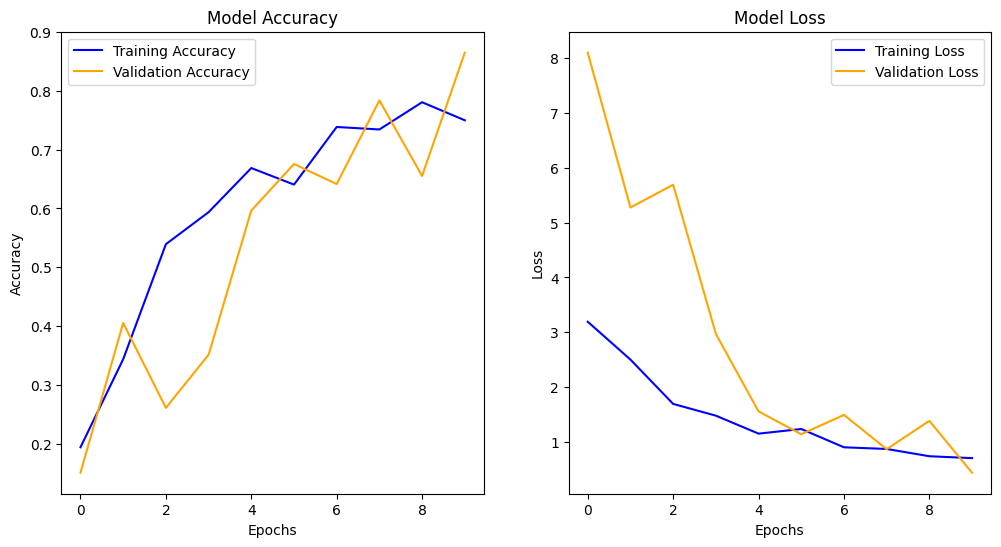

In [49]:
import matplotlib.pyplot as plt

# رسم منحنى الدقة
plt.figure(figsize=(12, 6))

# رسم منحنى الدقة
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


In [ ]:
xception_model.save('/kaggle/working/xception_model.h5')

In [ ]:
# from tensorflow.keras.models import load_model
# xception_model = load_model('/kaggle/working/xception_model.h5')
# print("ضن")
# xception_model

In [ ]:
len(val_generator)

In [62]:
all_imgs = []
all_labels = []

for i in range(len(val_generator)):
    imgs, labels = next(val_generator)
    all_imgs.append(imgs)
    all_labels.append(labels)

# تحويل القوائم إلى مصفوفات
all_imgs = np.vstack(all_imgs)
all_labels = np.vstack(all_labels)

# التنبؤ بكل الصور دفعة واحدة
y_pred = xception_model.predict(all_imgs)

# تحويل التنبؤات إلى الفئات
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(all_labels, axis=1)

print("Predicted Classes:", y_pred_classes[30:40])
print("True Classes:", y_true_classes[30:40])

36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step
Predicted Classes: [ 1  1  1  1  1 46  1 49  1 32]
True Classes: [1 1 1 1 1 1 1 1 1 1]


In [ ]:
# for true_label, pred_label in zip(y_true_classes, y_pred_classes):
#     print(f"True: {true_label}, Predicted: {pred_label}")


In [52]:
xception_accuracy = accuracy_score(y_true_classes,y_pred_classes)
print(f"Xception Accuracy: {xception_accuracy:.2f}")

Xception Accuracy: 0.66


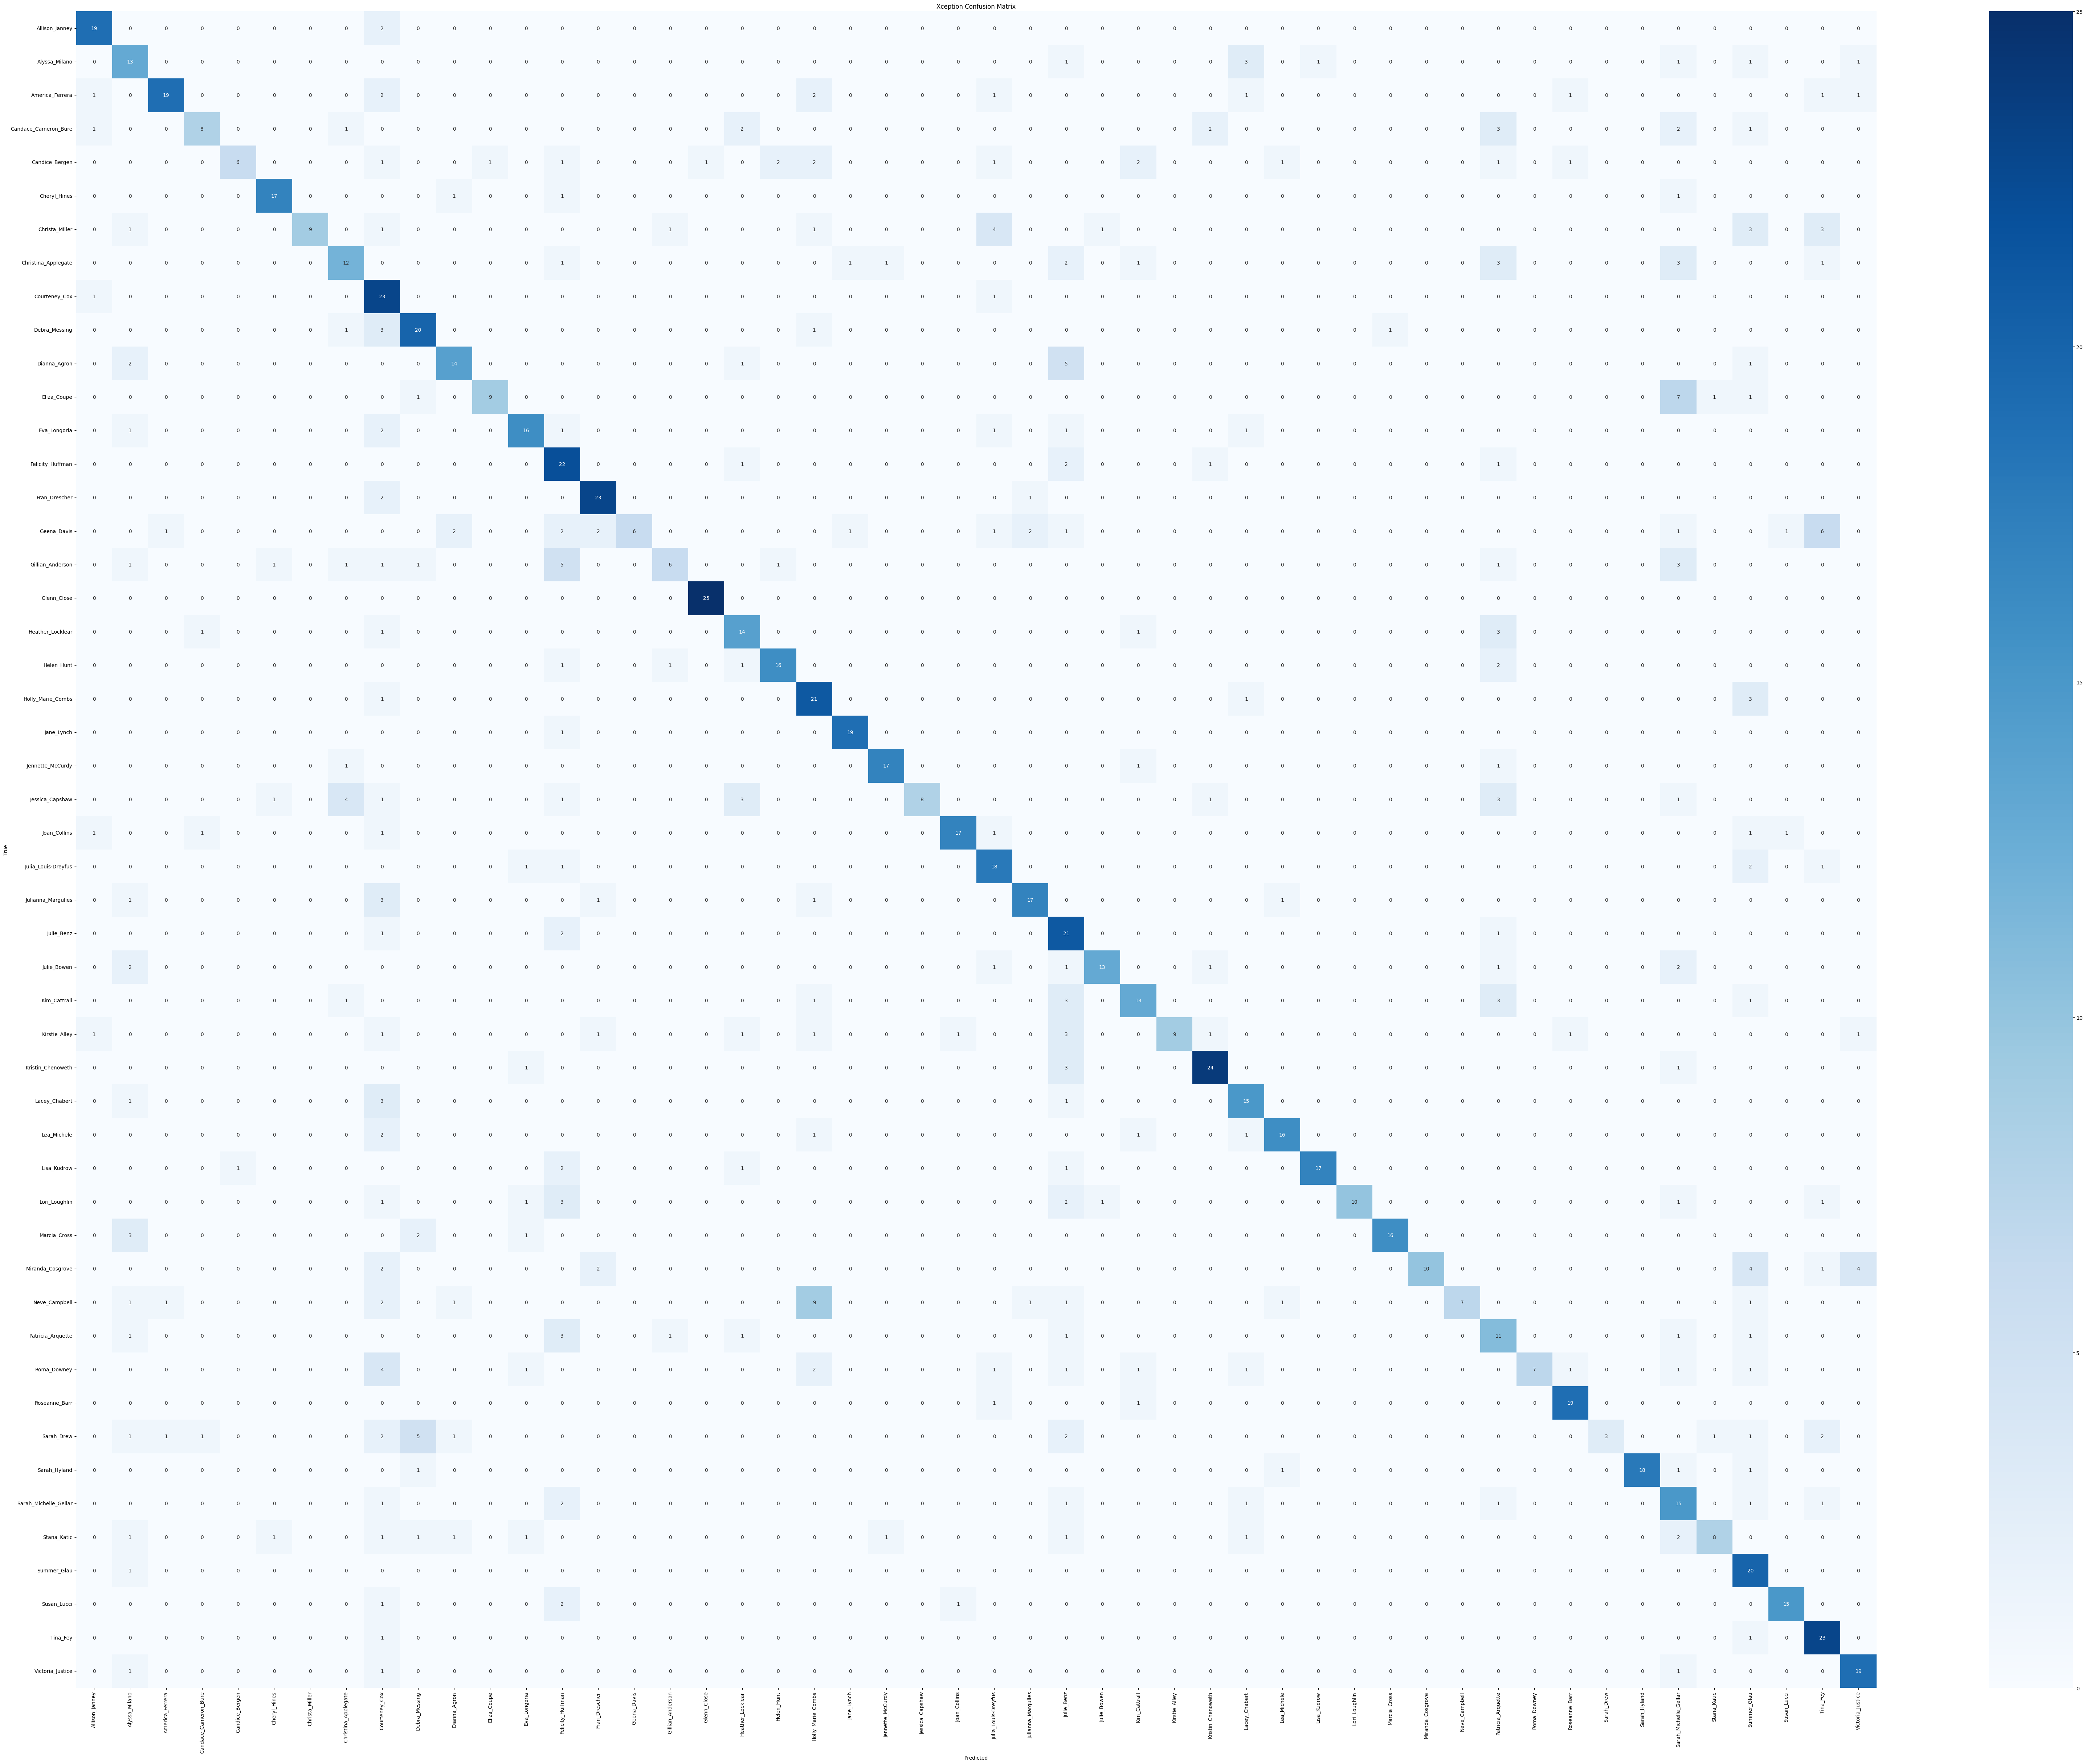

In [63]:
xception_cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(80, 60))
sns.heatmap(xception_cm, annot=True, fmt="d", cmap="Blues", xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title("Xception Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [64]:
xception_classification_report = classification_report(y_true_classes, y_pred_classes, target_names=val_generator.class_indices.keys())
print("Xception Classification Report:\n", xception_classification_report)

Xception Classification Report:
                        precision    recall  f1-score   support

       Allison_Janney       0.79      0.90      0.84        21
        Alyssa_Milano       0.42      0.62      0.50        21
      America_Ferrera       0.86      0.66      0.75        29
 Candace_Cameron_Bure       0.73      0.40      0.52        20
       Candice_Bergen       0.86      0.30      0.44        20
         Cheryl_Hines       0.85      0.85      0.85        20
       Christa_Miller       1.00      0.38      0.55        24
  Christina_Applegate       0.57      0.48      0.52        25
        Courteney_Cox       0.34      0.92      0.50        25
        Debra_Messing       0.65      0.77      0.70        26
         Dianna_Agron       0.70      0.61      0.65        23
          Eliza_Coupe       0.90      0.47      0.62        19
         Eva_Longoria       0.73      0.70      0.71        23
     Felicity_Huffman       0.43      0.81      0.56        27
        Fran_Drescher

In [65]:

# تحويل التقرير إلى dictionary باستخدام output_dict=True
xception_classification_report_dic = classification_report(y_true_classes, y_pred_classes, target_names=val_generator.class_indices.keys(), output_dict=True)

# حساب المتوسطات:
precision_avg = xception_classification_report_dic['accuracy']  # لو كنت عايز تشوف ال accuracy
recall_avg = xception_classification_report_dic['macro avg']['recall']  # المتوسط للموديل لكل الفئات لل recall
f1_avg = xception_classification_report_dic['macro avg']['f1-score']  # المتوسط للموديل لكل الفئات لل f1-score

print("Macro Average Recall:", recall_avg)
print("Macro Average Precision:", precision_avg)
print("Macro Average F1-Score:", f1_avg)


Macro Average Recall: 0.6560490079366904
Macro Average Precision: 0.6604444444444444
Macro Average F1-Score: 0.657139428753677


In [66]:

# Precision, Recall, F1-Score
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Xception Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

Xception Metrics:
Precision: 0.76
Recall: 0.66
F1-Score: 0.66


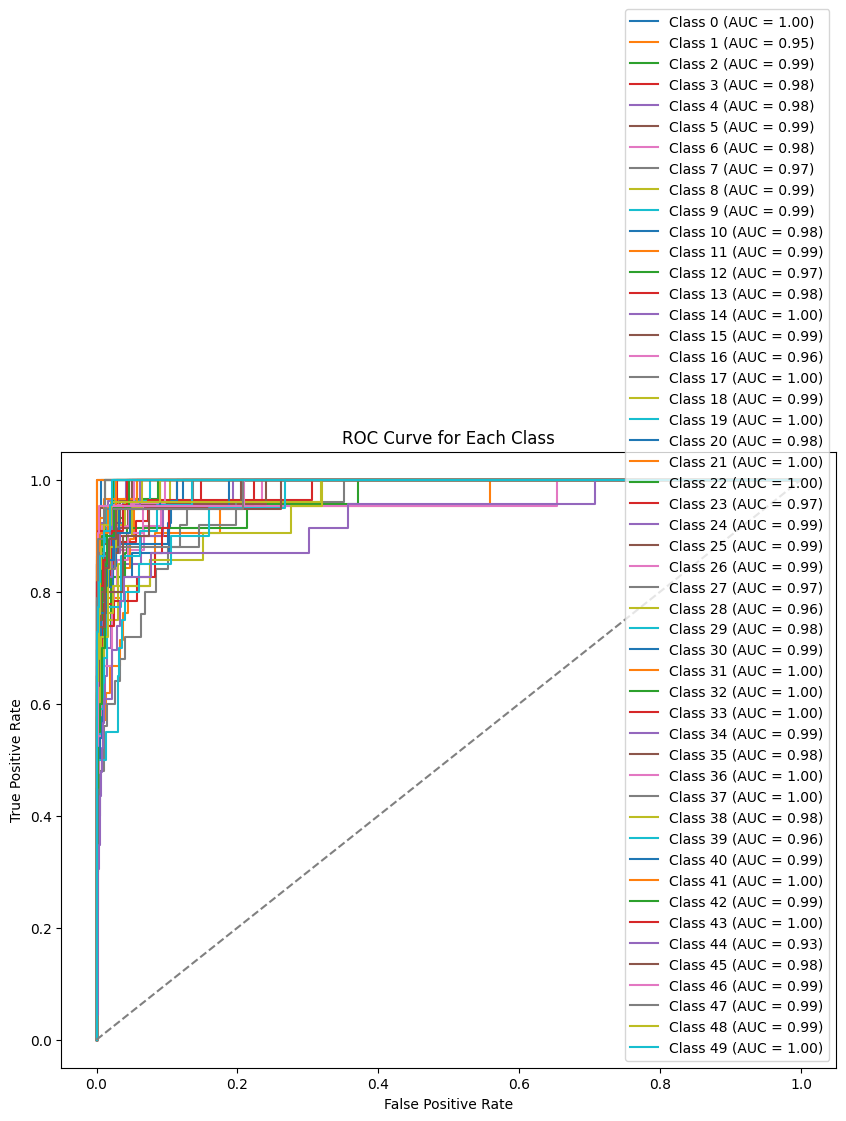

In [67]:
n_classes = all_labels.shape[1]  # number of classes
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_pred_bin = y_pred  # The raw prediction probabilities

# Plot ROC curve for each class
plt.figure(figsize=(10, 8))

for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    
    # Plotting each class ROC curve
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot random classifier (diagonal)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Each Class')
plt.legend(loc='lower right')

# Show the plot
plt.show()

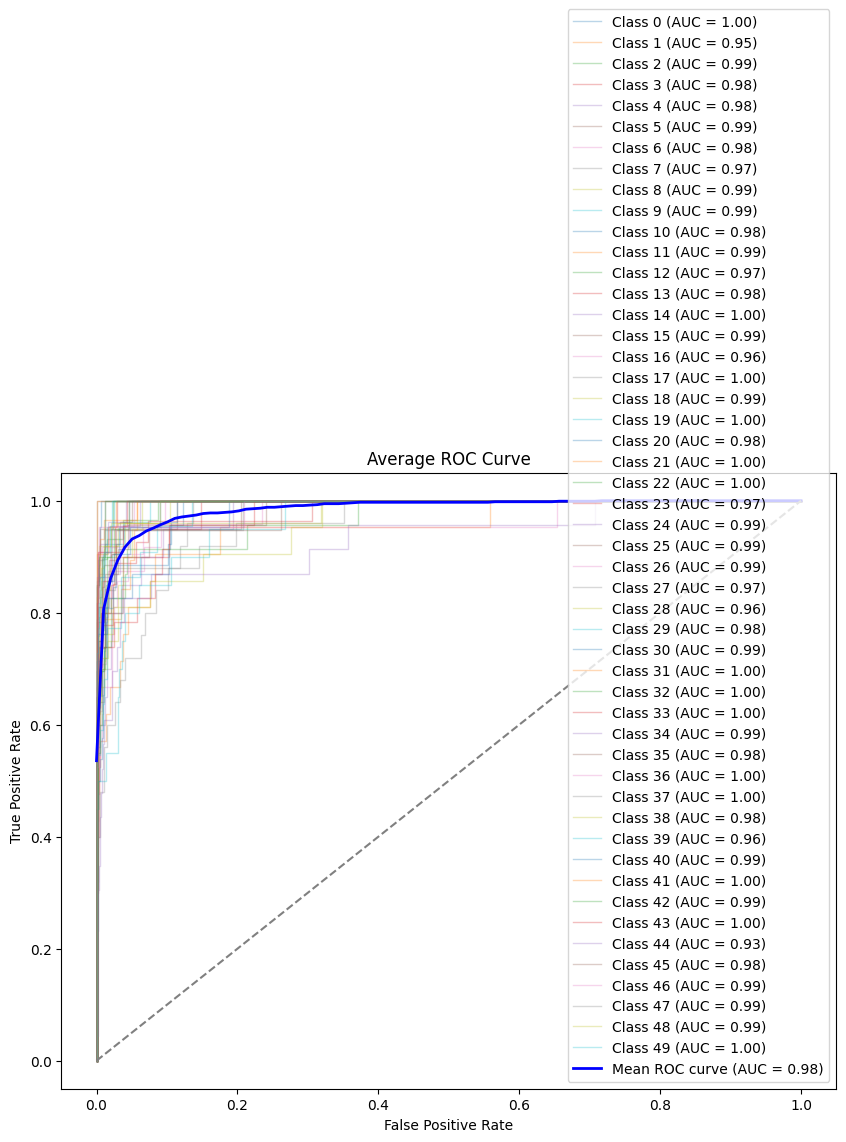

In [68]:
n_classes = all_labels.shape[1]  # number of classes
y_true_bin = label_binarize(y_true_classes, classes=np.arange(n_classes))
y_pred_bin = y_pred  # The raw prediction probabilities

fpr_all = []
tpr_all = []
roc_auc_all = []

# Compute ROC curve and AUC for each class
for i in range(n_classes):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_bin[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_all.append(fpr)
    tpr_all.append(tpr)
    roc_auc_all.append(roc_auc)

# Calculate the mean ROC curve
# First, interpolate the TPR at common FPR points
mean_fpr = np.linspace(0, 1, 100)
mean_tpr = np.zeros_like(mean_fpr)

for i in range(n_classes):
    mean_tpr += np.interp(mean_fpr, fpr_all[i], tpr_all[i])

mean_tpr /= n_classes

# Calculate the AUC for the average ROC curve
mean_roc_auc = auc(mean_fpr, mean_tpr)

# Plotting the ROC curves for each class and the average curve
plt.figure(figsize=(10, 8))

# Plot the individual class ROC curves
for i in range(n_classes):
    plt.plot(fpr_all[i], tpr_all[i], lw=1, alpha=0.3, label=f'Class {i} (AUC = {roc_auc_all[i]:.2f})')

# Plot the average ROC curve
plt.plot(mean_fpr, mean_tpr, color='b', label=f'Mean ROC curve (AUC = {mean_roc_auc:.2f})', lw=2)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [69]:
print("Training ResNet...")

history_resnet = resnet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,  # إضافة بيانات التحقق
    validation_steps=val_generator.samples // val_generator.batch_size  # تحديد خطوات التحقق
)
# تقييم ResNet
resnet_loss, resnet_acc = resnet_model.evaluate(val_generator)
print(f"ResNet Accuracy: {resnet_acc:.2f}")


Training ResNet...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 174s 2s/step - accuracy: 0.0350 - loss: 5.7664 - val_accuracy: 0.0211 - val_loss: 4.1714
Epoch 2/10
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2:19 2s/step - accuracy: 0.0781 - loss: 3.6200

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0781 - loss: 3.6200 - val_accuracy: 0.0000e+00 - val_loss: 4.2550
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.0707 - loss: 3.8177 - val_accuracy: 0.0239 - val_loss: 4.9111
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0938 - loss: 3.8131 - val_accuracy: 0.0000e+00 - val_loss: 6.5737
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.1092 - loss: 3.5320 - val_accuracy: 0.0349 - val_loss: 4.5485
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.0625 - loss: 3.5598 - val_accuracy: 0.0000e+00 - val_loss: 5.6590
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy: 0.1241 - loss: 3.3513 - val_accuracy: 0.0744 - val_loss: 4.4187
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.2188 - loss: 3.1665 - val_accuracy: 0.0000e+00 - val_loss: 5.5394
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 166s 2s/step - accuracy: 0.1657 - loss: 3.1797 - val_accuracy: 0.0781 - 

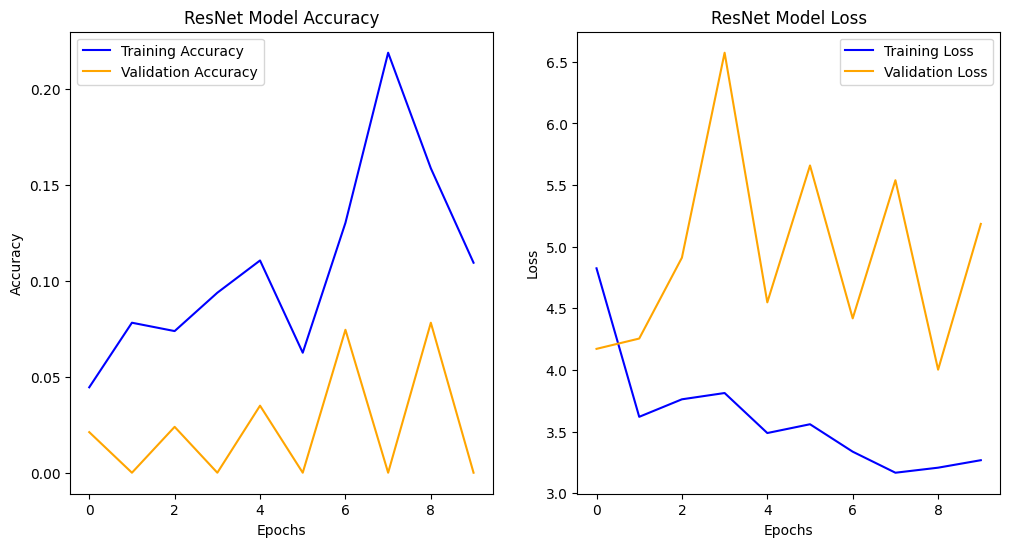

In [70]:
plt.figure(figsize=(12, 6))

# رسم منحنى الدقة
plt.subplot(1, 2, 1)
plt.plot(history_resnet.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history_resnet.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('ResNet Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# رسم منحنى الخسارة
plt.subplot(1, 2, 2)
plt.plot(history_resnet.history['loss'], label='Training Loss', color='blue')
plt.plot(history_resnet.history['val_loss'], label='Validation Loss', color='orange')
plt.title('ResNet Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [71]:
print(f"Evaluating ResNet ...")

all_imgs_resnet = []
all_labels_resnet = []

# Assuming `val_generator` is your data generator
for i in range(len(val_generator)):
    imgs_resnet, labels_resnet = next(val_generator)
    all_imgs_resnet.append(imgs_resnet)
    all_labels_resnet.append(labels_resnet)

# Convert the lists to arrays
all_imgs_resnet = np.vstack(all_imgs_resnet)
all_labels_resnet = np.vstack(all_labels_resnet)

y_pred_resnet = resnet_model.predict(all_imgs_resnet)

# Convert predictions to classes
y_pred_classes_resnet = np.argmax(y_pred_resnet, axis=1)
y_true_classes_resnet = np.argmax(all_labels_resnet, axis=1)

# Display the results
print("Predicted Classes (ResNet):", y_pred_classes_resnet[:10])
print("True Classes (ResNet):", y_true_classes_resnet[:10])

Evaluating ResNet ...
36/36 ━━━━━━━━━━━━━━━━━━━━ 8s 213ms/step
Predicted Classes (ResNet): [34  6 27 11 35 11  6 11  6  6]
True Classes (ResNet): [0 0 0 0 0 0 0 0 0 0]


In [72]:
from sklearn.metrics import accuracy_score

# حساب الدقة
accuracy = accuracy_score(y_true_classes_resnet, y_pred_classes_resnet)
print(f"Accuracy: {accuracy:.2f}")

Accuracy: 0.07


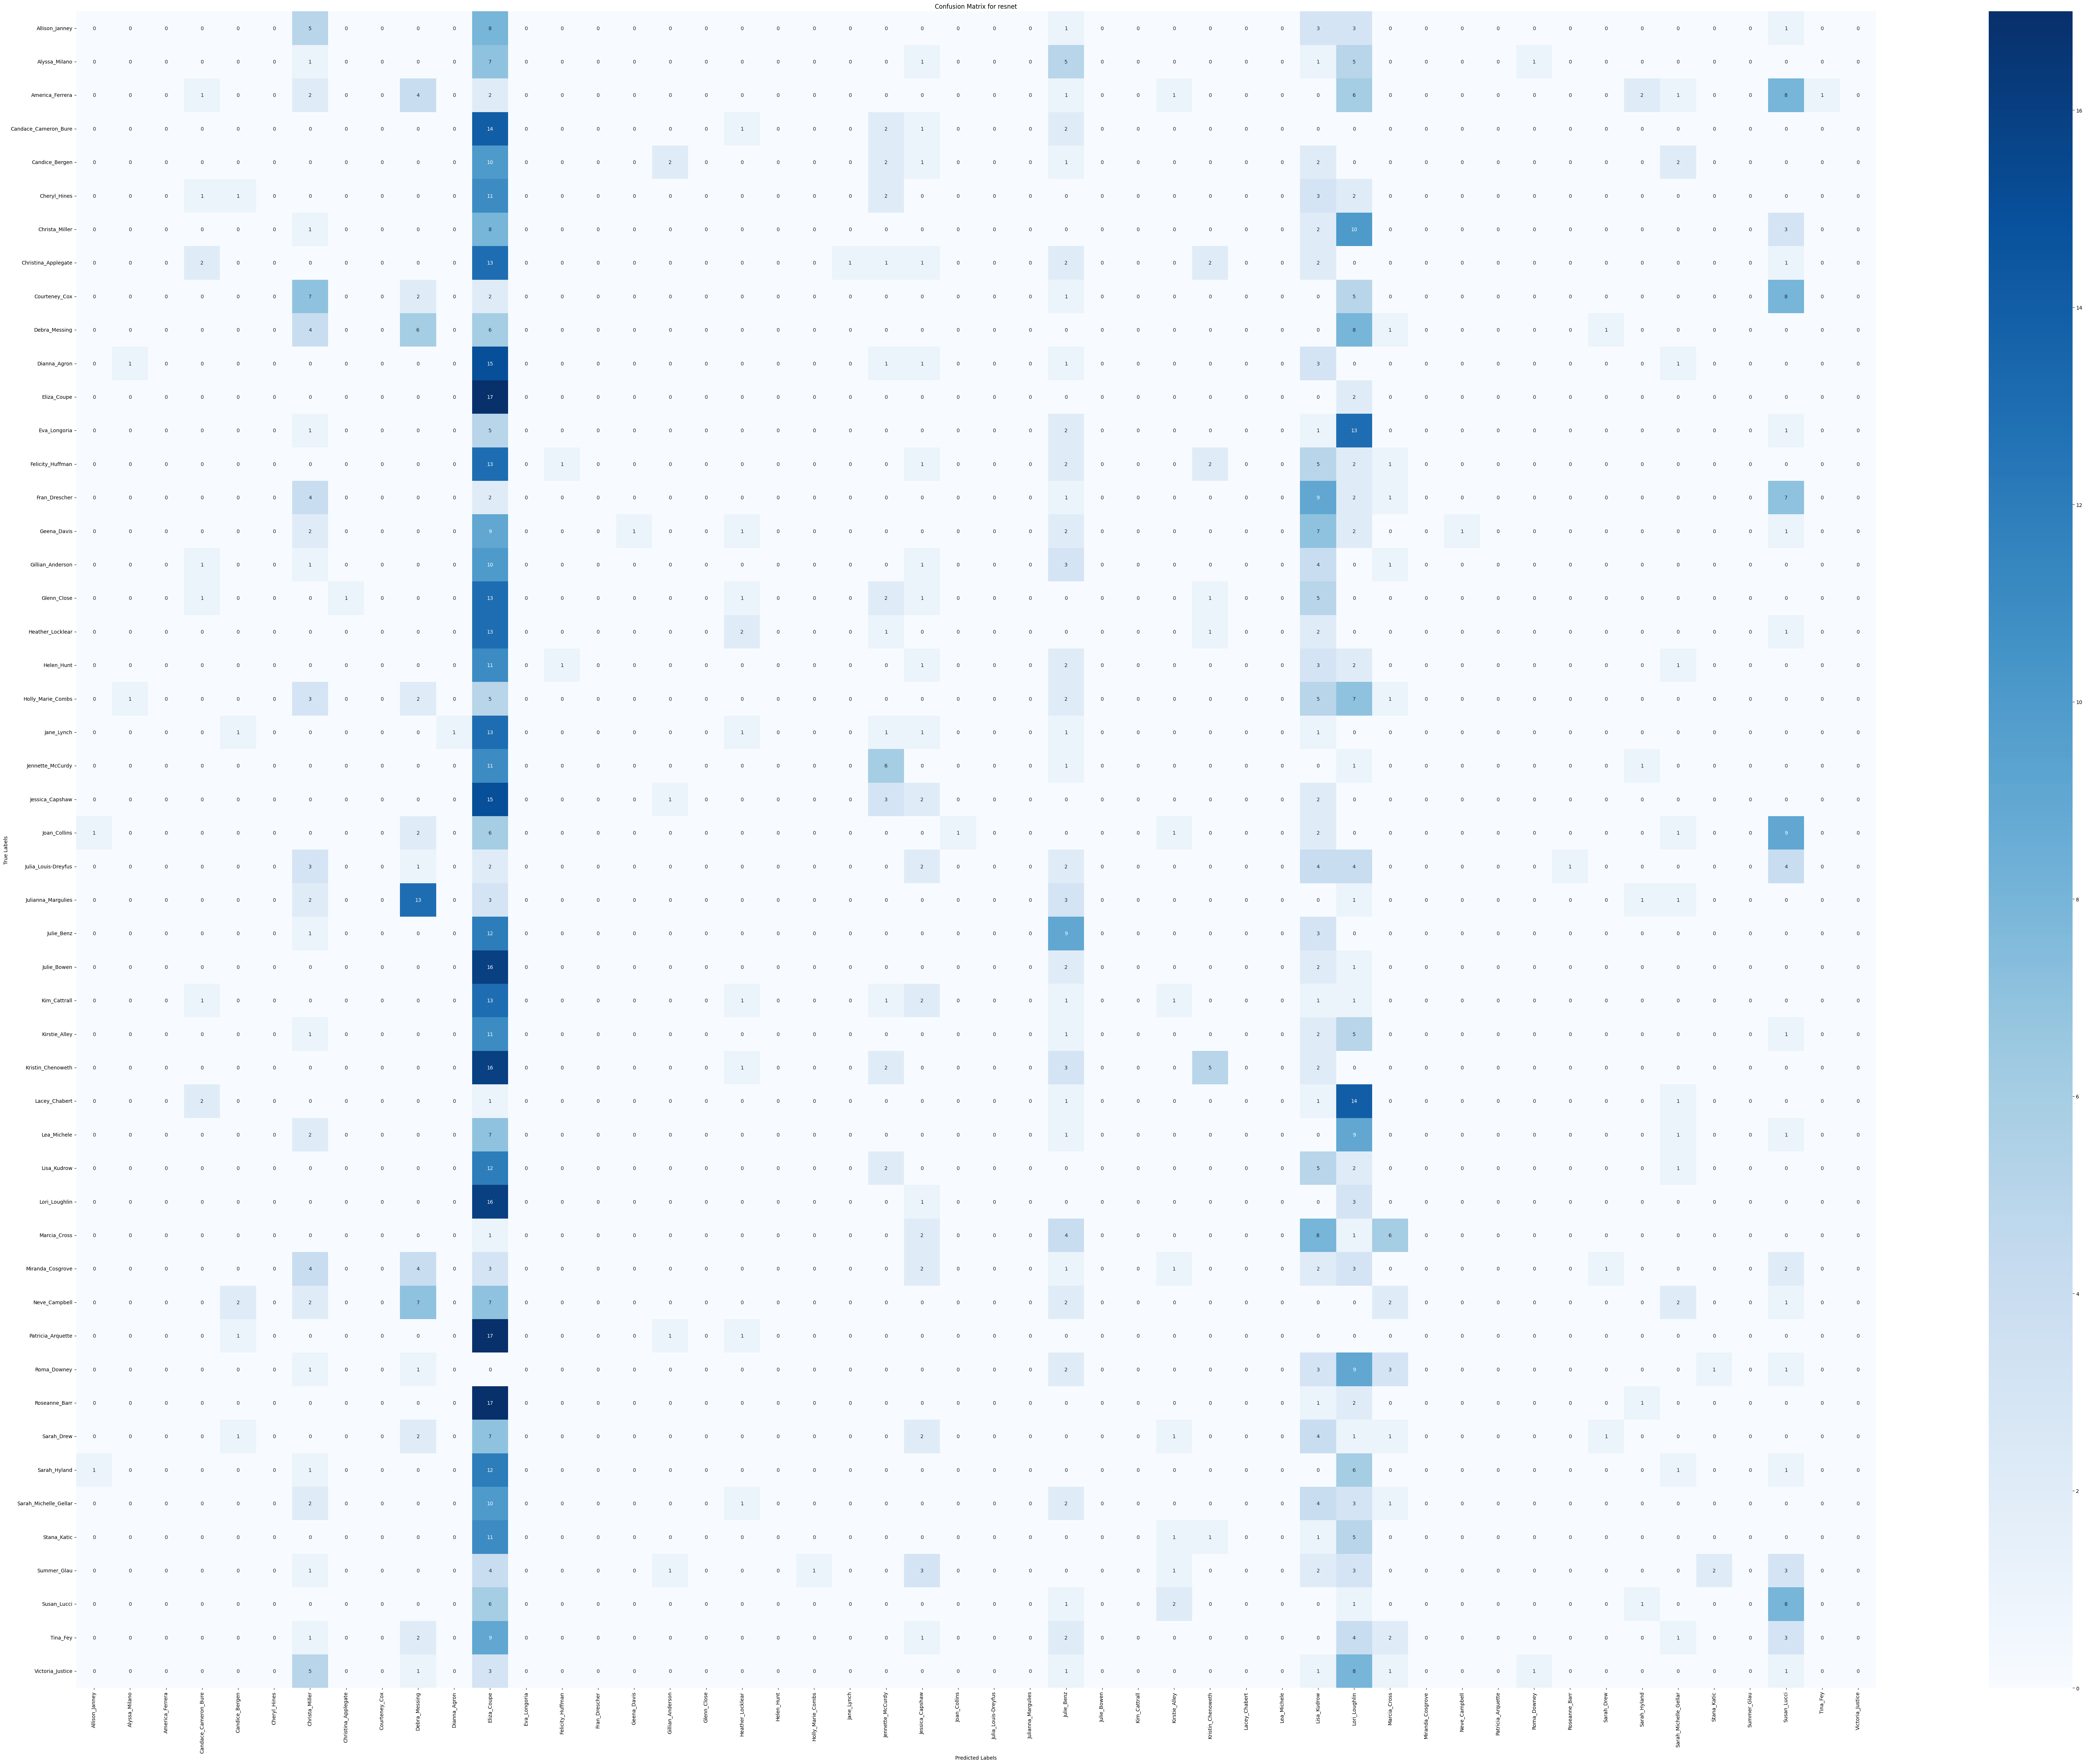

In [73]:
cm = confusion_matrix(y_true_classes_resnet, y_pred_classes_resnet)

# رسم confusion matrix باستخدام seaborn
plt.figure(figsize=(80, 60))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title(f"Confusion Matrix for resnet")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [74]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1-Score
precision = precision_score(y_true_classes_resnet, y_pred_classes_resnet, average='weighted')
recall = recall_score(y_true_classes_resnet, y_pred_classes_resnet, average='weighted')
f1 = f1_score(y_true_classes_resnet, y_pred_classes_resnet, average='weighted')

print("ResNet Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

ResNet Metrics:
Precision: 0.10
Recall: 0.07
F1-Score: 0.04


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


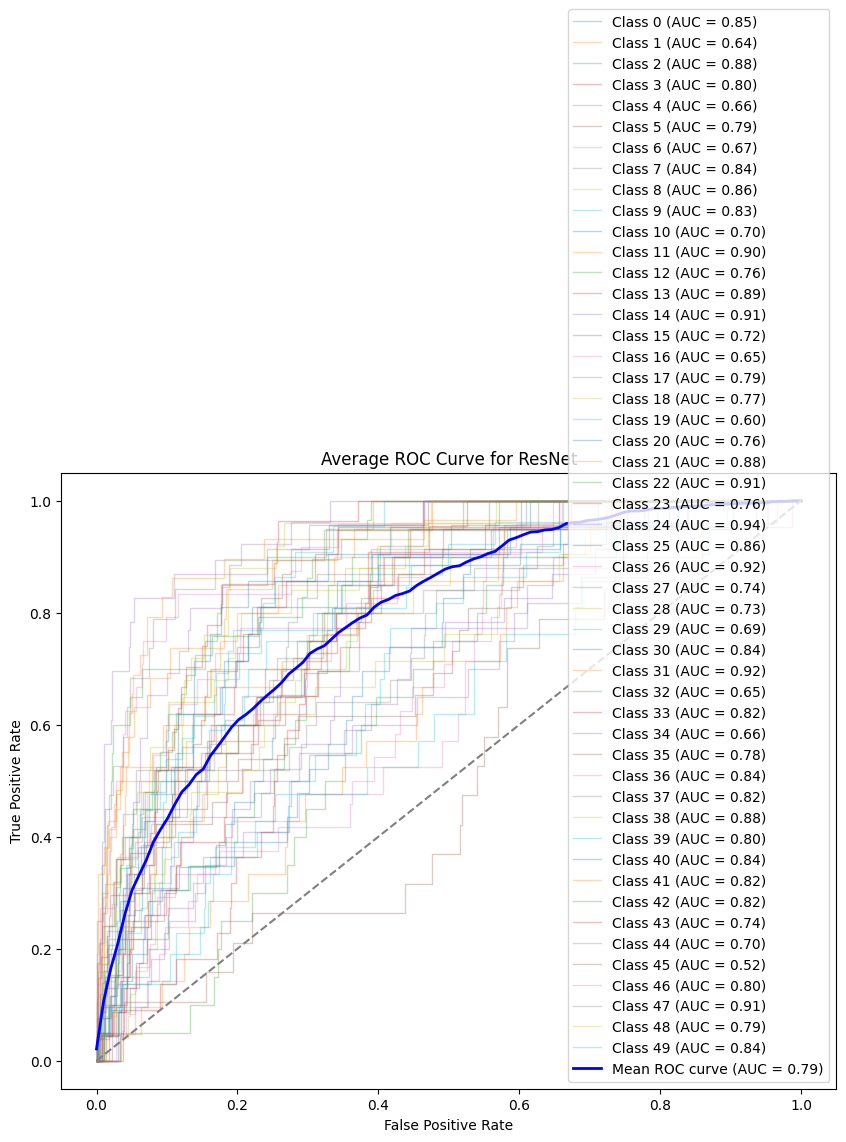

In [75]:
n_classes_resnet = all_labels_resnet.shape[1]  # number of classes
y_true_bin_resnet = label_binarize(y_true_classes_resnet, classes=np.arange(n_classes_resnet))
y_pred_bin_resnet = y_pred_resnet  # The raw prediction probabilities from ResNet

# Initialize variables to store FPR, TPR, and AUC for each class
fpr_all_resnet = []
tpr_all_resnet = []
roc_auc_all_resnet = []

# Compute ROC curve and AUC for each class
for i in range(n_classes_resnet):
    fpr, tpr, _ = roc_curve(y_true_bin_resnet[:, i], y_pred_bin_resnet[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_all_resnet.append(fpr)
    tpr_all_resnet.append(tpr)
    roc_auc_all_resnet.append(roc_auc)

# Calculate the mean ROC curve
# First, interpolate the TPR at common FPR points
mean_fpr_resnet = np.linspace(0, 1, 100)
mean_tpr_resnet = np.zeros_like(mean_fpr_resnet)

for i in range(n_classes_resnet):
    mean_tpr_resnet += np.interp(mean_fpr_resnet, fpr_all_resnet[i], tpr_all_resnet[i])

mean_tpr_resnet /= n_classes_resnet

# Calculate the AUC for the average ROC curve
mean_roc_auc_resnet = auc(mean_fpr_resnet, mean_tpr_resnet)

# Plotting the ROC curves for each class and the average curve
plt.figure(figsize=(10, 8))

# Plot the individual class ROC curves
for i in range(n_classes_resnet):
    plt.plot(fpr_all_resnet[i], tpr_all_resnet[i], lw=1, alpha=0.3, label=f'Class {i} (AUC = {roc_auc_all_resnet[i]:.2f})')

# Plot the average ROC curve
plt.plot(mean_fpr_resnet, mean_tpr_resnet, color='b', label=f'Mean ROC curve (AUC = {mean_roc_auc_resnet:.2f})', lw=2)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve for ResNet')
plt.legend(loc='lower right')

# Show the plot
plt.show()

In [76]:
print("Training DenseNet...")
history = densenet_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=10,
    validation_data=val_generator,  # للتقييم أثناء التدريب
    validation_steps=val_generator.samples // val_generator.batch_size
)

# تقييم النموذج
densenet_loss, densenet_acc = densenet_model.evaluate(val_generator)
print(f"DenseNet Accuracy: {densenet_acc:.2f}")
print(f"DenseNet Loss: {densenet_loss:.2f}")


Training DenseNet...
Epoch 1/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.0903 - loss: 3.8528 - val_accuracy: 0.2050 - val_loss: 2.9645
Epoch 2/10
 1/71 ━━━━━━━━━━━━━━━━━━━━ 2:18 2s/step - accuracy: 0.2656 - loss: 3.2109

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.2656 - loss: 3.2109 - val_accuracy: 0.5405 - val_loss: 1.3593
Epoch 3/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.3235 - loss: 2.4993 - val_accuracy: 0.4246 - val_loss: 2.1457
Epoch 4/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.5000 - loss: 1.9350 - val_accuracy: 0.5135 - val_loss: 1.4702
Epoch 5/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 189s 3s/step - accuracy: 0.4748 - loss: 1.9081 - val_accuracy: 0.5064 - val_loss: 1.7602
Epoch 6/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 14ms/step - accuracy: 0.4531 - loss: 1.9414 - val_accuracy: 0.6216 - val_loss: 1.3889
Epoch 7/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 192s 3s/step - accuracy: 0.5828 - loss: 1.5064 - val_accuracy: 0.5680 - val_loss: 1.4403
Epoch 8/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.6250 - loss: 1.3280 - val_accuracy: 0.5676 - val_loss: 1.6914
Epoch 9/10
71/71 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6412 - loss: 1.2924 - val_accuracy: 0.6029 - val_loss: 1.

In [77]:
print(f"Evaluating DenseNet ...")

all_imgs_densenet = []
all_labels_densenet = []

# Assuming `val_generator` is your data generator
for i in range(len(val_generator)):
    imgs_densenet, labels_densenet = next(val_generator)
    all_imgs_densenet.append(imgs_densenet)
    all_labels_densenet.append(labels_densenet)

# Convert the lists to arrays
all_imgs_densenet = np.vstack(all_imgs_densenet)
all_labels_densenet = np.vstack(all_labels_densenet)

# Assuming `densenet_model` is your DenseNet model
y_pred_densenet = densenet_model.predict(all_imgs_densenet)

# Convert predictions to classes
y_pred_classes_densenet = np.argmax(y_pred_densenet, axis=1)
y_true_classes_densenet = np.argmax(all_labels_densenet, axis=1)

# Display the results
print("Predicted Classes (DenseNet):", y_pred_classes_densenet[:10])
print("True Classes (DenseNet):", y_true_classes_densenet[:10])


Evaluating DenseNet ...
36/36 ━━━━━━━━━━━━━━━━━━━━ 37s 929ms/step
Predicted Classes (DenseNet): [0 0 0 3 0 0 0 3 0 0]
True Classes (DenseNet): [0 0 0 0 0 0 0 0 0 0]


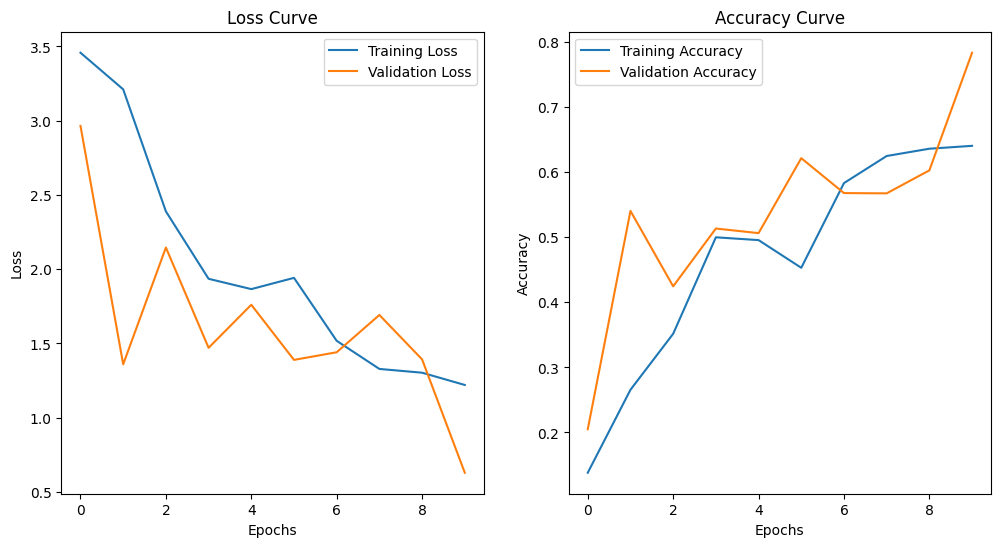

In [78]:
# رسم منحنى الخسارة
plt.figure(figsize=(12, 6))

# رسم منحنى الخسارة
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# رسم منحنى الدقة
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()


In [79]:
from sklearn.metrics import accuracy_score

# حساب الدقة
accuracy_densenet = accuracy_score(y_true_classes_densenet, y_pred_classes_densenet)
print(f"Accuracy (DenseNet): {accuracy_densenet:.2f}")

Accuracy (DenseNet): 0.61


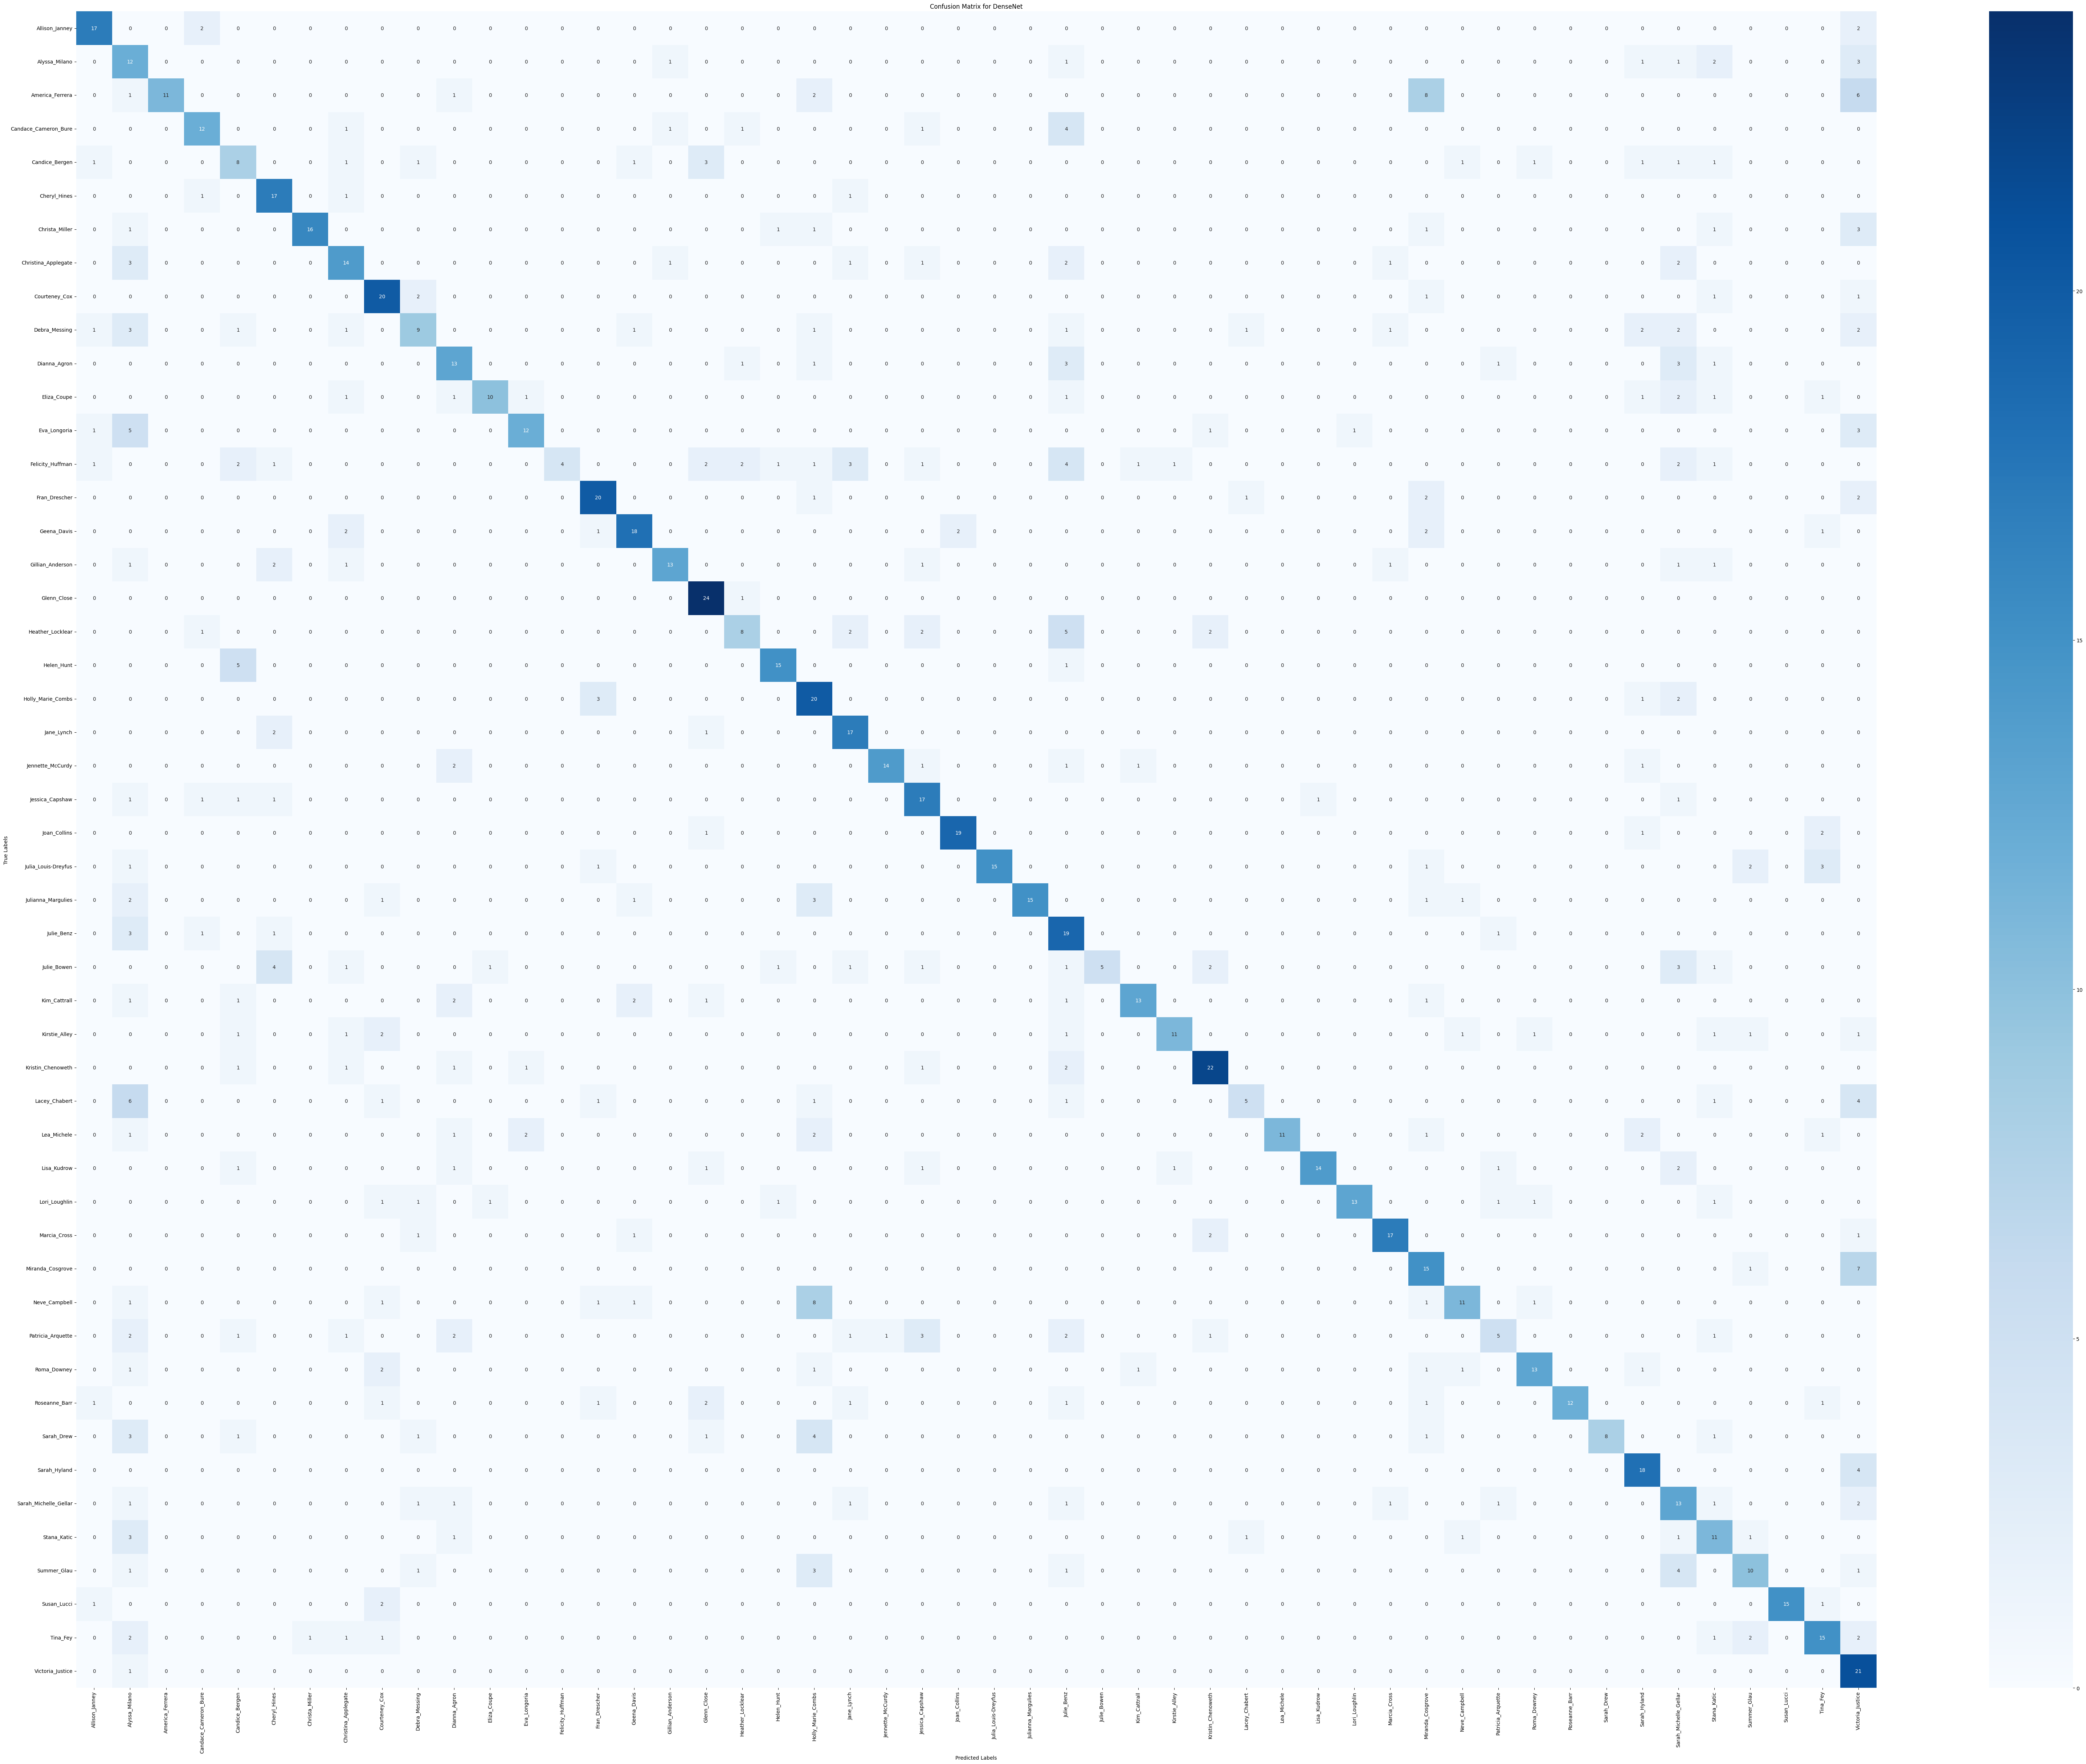

In [80]:
cm_densenet = confusion_matrix(y_true_classes_densenet, y_pred_classes_densenet)

# رسم confusion matrix باستخدام seaborn
plt.figure(figsize=(80, 60))  # Adjust the figure size for better readability
sns.heatmap(cm_densenet, annot=True, fmt='d', cmap='Blues', xticklabels=val_generator.class_indices.keys(), yticklabels=val_generator.class_indices.keys())
plt.title(f"Confusion Matrix for DenseNet")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

In [81]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Precision, Recall, F1-Score
precision = precision_score(y_true_classes_densenet, y_pred_classes_densenet, average='weighted')
recall = recall_score(y_true_classes_densenet, y_pred_classes_densenet, average='weighted')
f1 = f1_score(y_true_classes_densenet, y_pred_classes_densenet, average='weighted')

print("densenet Metrics:")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")

densenet Metrics:
Precision: 0.70
Recall: 0.61
F1-Score: 0.62


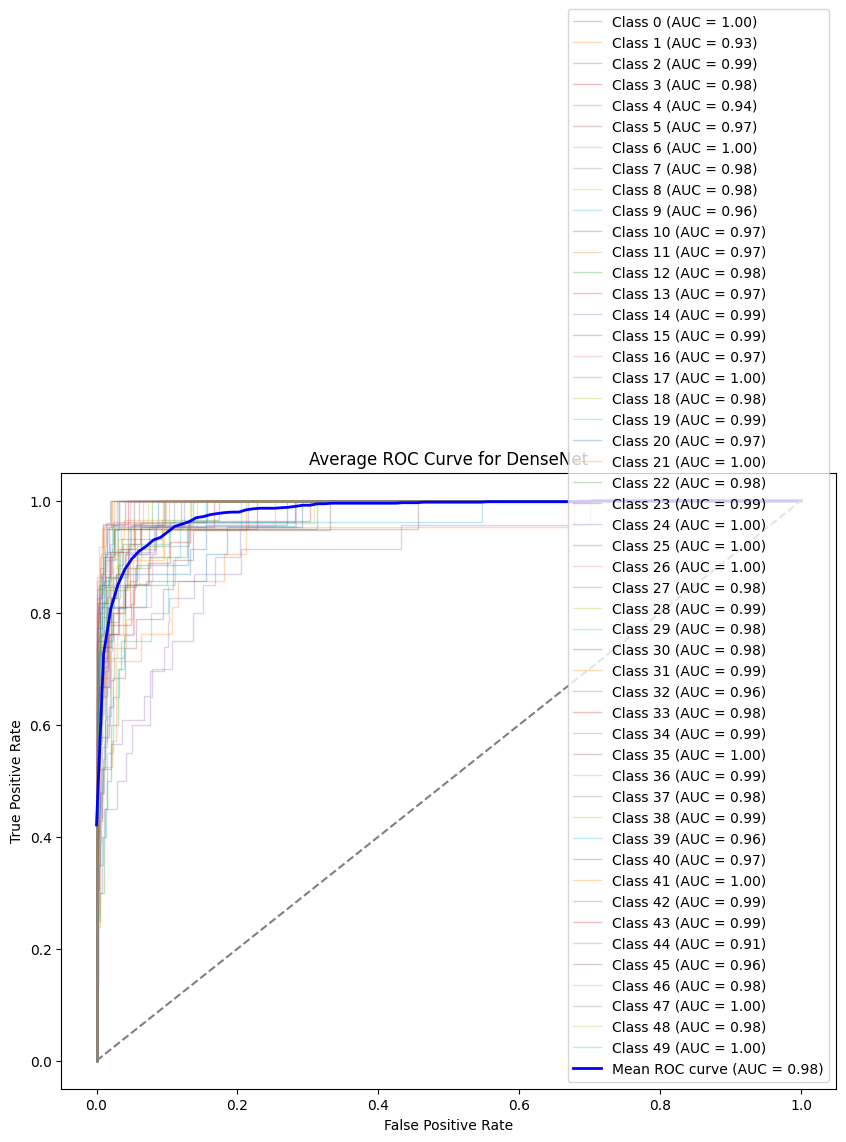

In [82]:
from sklearn.preprocessing import label_binarize
n_classes_densenet = all_labels_densenet.shape[1]  # Number of classes
y_true_bin_densenet = label_binarize(y_true_classes_densenet, classes=np.arange(n_classes_densenet))
y_pred_bin_densenet = y_pred_densenet  # The raw prediction probabilities from DenseNet

# Initialize variables to store FPR, TPR, and AUC for each class
fpr_all_densenet = []
tpr_all_densenet = []
roc_auc_all_densenet = []

# Compute ROC curve and AUC for each class
for i in range(n_classes_densenet):
    fpr, tpr, _ = roc_curve(y_true_bin_densenet[:, i], y_pred_bin_densenet[:, i])
    roc_auc = auc(fpr, tpr)
    fpr_all_densenet.append(fpr)
    tpr_all_densenet.append(tpr)
    roc_auc_all_densenet.append(roc_auc)

# Calculate the mean ROC curve
# First, interpolate the TPR at common FPR points
mean_fpr_densenet = np.linspace(0, 1, 100)
mean_tpr_densenet = np.zeros_like(mean_fpr_densenet)

for i in range(n_classes_densenet):
    mean_tpr_densenet += np.interp(mean_fpr_densenet, fpr_all_densenet[i], tpr_all_densenet[i])

mean_tpr_densenet /= n_classes_densenet

# Calculate the AUC for the average ROC curve
mean_roc_auc_densenet = auc(mean_fpr_densenet, mean_tpr_densenet)

# Plotting the ROC curves for each class and the average curve
plt.figure(figsize=(10, 8))

# Plot the individual class ROC curves
for i in range(n_classes_densenet):
    plt.plot(fpr_all_densenet[i], tpr_all_densenet[i], lw=1, alpha=0.3, label=f'Class {i} (AUC = {roc_auc_all_densenet[i]:.2f})')

# Plot the average ROC curve
plt.plot(mean_fpr_densenet, mean_tpr_densenet, color='b', label=f'Mean ROC curve (AUC = {mean_roc_auc_densenet:.2f})', lw=2)

# Plot the diagonal (random classifier)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

# Customizing the plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Average ROC Curve for DenseNet')
plt.legend(loc='lower right')

# Show the plot
plt.show()
